In [1]:
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary

In [5]:
amtrak_df = pd.read_csv(r"C:\Users\patri\Documents\Making_Data_Decisions_Files\dmba-datasets\dmba\Amtrak.csv")
#convert date info to datetime object
amtrak_df['Date'] = pd.to_datetime(amtrak_df.Month, format='%d/%m/%Y')

In [7]:
#Convert dataframe column to a series name is used to label the data
#This creates a new dataframe where the ridership values are the first column and they are indexed by the date values
ridership_ts = pd.Series(amtrak_df.Ridership.values, index = amtrak_df.Date, name='Ridership')

In [8]:
#Define time series frequency
ridership_ts.index=pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

(1300.0, 2300.0)

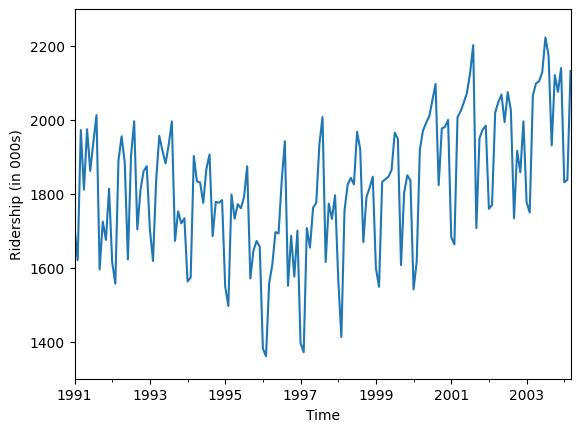

In [9]:
#plot it
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300,2300)

In [19]:
# create shorter time series, 1997-1999
ridership_ts_3yrs = ridership_ts['1997':'1999']
#create a dataframe with additional predictors from time series
#the following commands adds a constant term, a trend term and a quadratic trend term
ridership_df= tsatools.add_trend(ridership_ts, trend='ctt')
#fit a linear regression model to the time series
ridership_lm = sm.ols(formula = 'Ridership ~ trend + trend_squared', data=ridership_df).fit()

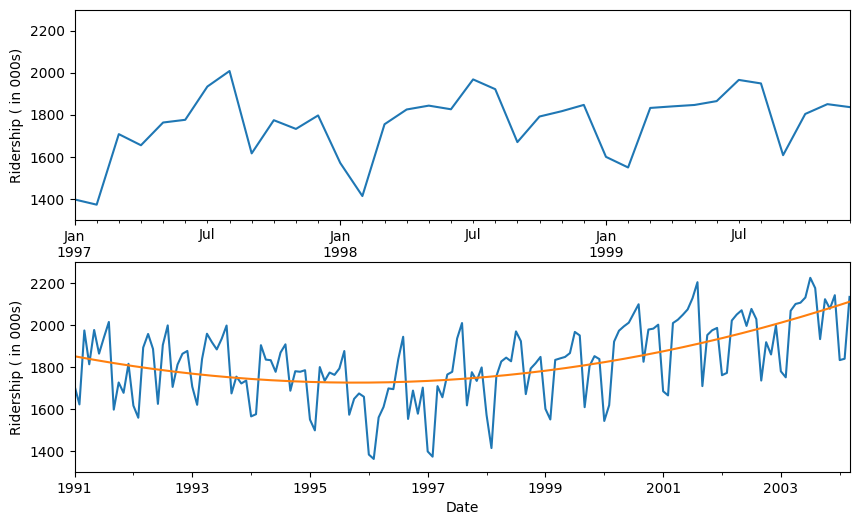

In [25]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
ridership_ts_3yrs.plot(ax=axes[0])
ridership_ts.plot(ax=axes[1])
for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership ( in 000s)')
    ax.set_ylim(1300,2300)
ridership_lm.predict(ridership_df).plot(ax=axes[1])
plt.show()

In [78]:
#Start with Naive approach to use as a benchmark
#nValid is the number of months
nValid = 36
nTrain = len(ridership_ts) - nValid

In [79]:
#partition data
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

In [80]:
#generate the naive and seasonal naive forecast
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)
[:len(valid_ts)].values,
index=valid_ts.index)

C:\Users\patri\AppData\Local\Temp\ipykernel_91040\3057118723.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)


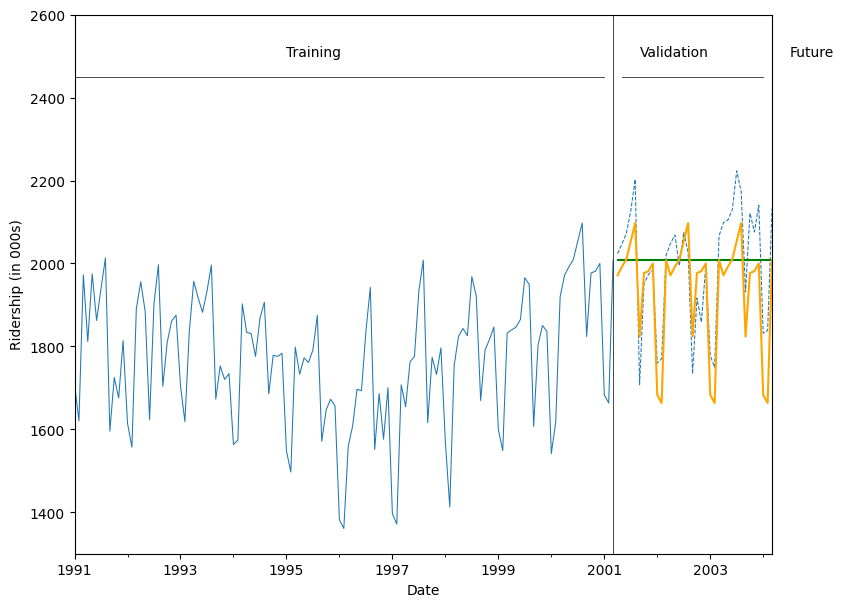

In [88]:
#plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color = 'C0', linestyle='dashed', linewidth = 0.75)
ax.set_xlim('1990', '2006-6')
ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')
#determine the coordinates of the lines
one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, '2006')
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])
ax.add_line(plt.Line2D(xtrain, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450 ,2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450 ,2450), color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validation')
ax.text('2004-7', 2500, 'Future')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.axvline(x=xvf, ymin= 0, ymax=1, color='black', linewidth=0.5)
plt.show()



In [90]:
#calculate metrics
regressionSummary(valid_ts, naive_pred)



Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214

Regression statistics

                      Mean Error (ME) : 2.4509
       Root Mean Squared Error (RMSE) : 168.1470
            Mean Absolute Error (MAE) : 125.2975
          Mean Percentage Error (MPE) : -0.3460
Mean Absolute Percentage Error (MAPE) : 7.2714


In [95]:
regressionSummary(valid_ts, seasonal_pred)


Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477


In [96]:
regressionSummary(train_ts[1:], train_ts[:-1])


Regression statistics

                      Mean Error (ME) : 2.4509
       Root Mean Squared Error (RMSE) : 168.1470
            Mean Absolute Error (MAE) : 125.2975
          Mean Percentage Error (MPE) : -0.3460
Mean Absolute Percentage Error (MAPE) : 7.2714


In [97]:
#calculate seasonal naive metrics for training set shift 12 months
regressionSummary(train_ts[12:], train_ts[:-12])


Regression statistics

                      Mean Error (ME) : 13.9399
       Root Mean Squared Error (RMSE) : 99.2656
            Mean Absolute Error (MAE) : 82.4920
          Mean Percentage Error (MPE) : 0.5851
Mean Absolute Percentage Error (MAPE) : 4.7153


In [104]:
#Lets move on to modeling, going to go ahead and reload all the data
amtrak_df = pd.read_csv(r"C:\Users\patri\Documents\Making_Data_Decisions_Files\dmba-datasets\dmba\Amtrak.csv")
#convert date info to datetime object
amtrak_df['Date'] = pd.to_datetime(amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(amtrak_df.Ridership.values, index = amtrak_df.Date, name = 'Ridership')

In [105]:
#fit a linear trend model to the time series
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_lm = sm.ols(formula = 'Ridership ~ trend', data=ridership_df).fit()

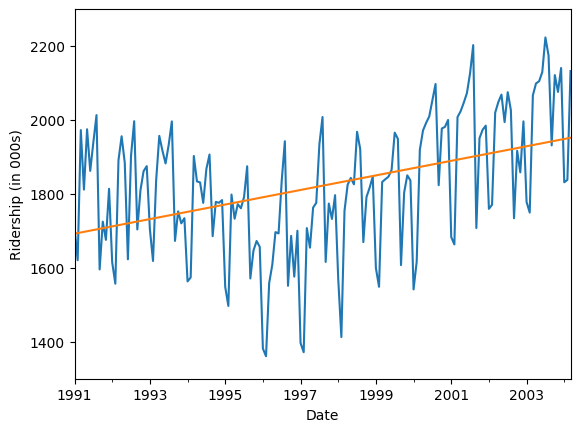

In [106]:
#shorter and longer time series
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300,2300)
ridership_lm.predict(ridership_df).plot(ax=ax)
plt.show()
#it's obvious from the plot that the global trend is not linear

In [123]:
#fit linear model using training set and predict on validation set
split_date = pd.Timestamp('2002-01-01')     # adjust to match the book’s split if needed
train_df = ridership_df.loc[:split_date].copy()
valid_df = ridership_df.loc[split_date + pd.offsets.MonthBegin(1):].copy()
ridership_lm = sm.ols(formula='Ridership ~ trend',
data=train_df).fit()
predict_df = ridership_lm.predict(valid_df)

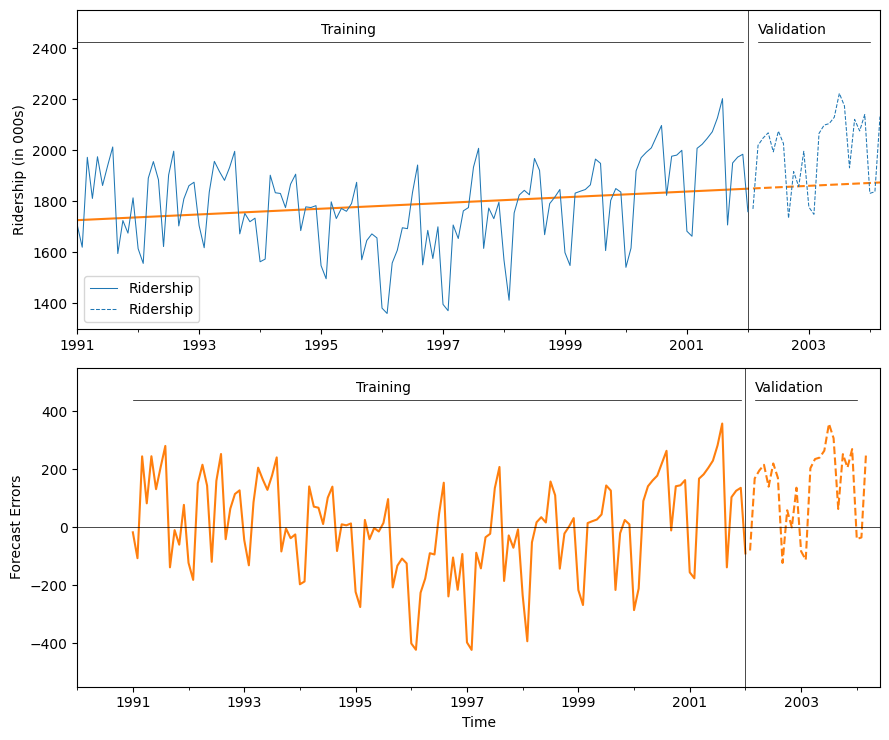

In [124]:

# fit linear model using training set and predict on validation

ridership_lm = sm.ols(formula='Ridership ~ trend',
data=train_df).fit()
predict_df = ridership_lm.predict(valid_df)
# create the plot

def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) -
    one_month)
    xvalid = (min(valid_df.index) + one_month,
    max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black',
    linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black',
    linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black',
    linewidth=0.5)
    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0',
    linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0',
    linestyle='dashed',
    linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black',
    linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
if axes[0].get_legend():
    axes[0].get_legend().remove()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_lm.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm.predict(valid_df).plot(ax=axes[0], color='C1',
linestyle='dashed')
residual = train_df.Ridership - ridership_lm.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)
613
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

In [125]:
ridership_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     6.259
Date:                Tue, 30 Sep 2025   Prob (F-statistic):             0.0136
Time:                        20:54:50   Log-Likelihood:                -867.11
No. Observations:                 133   AIC:                             1738.
Df Residuals:                     131   BIC:                             1744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1725.5369     28.843     59.825      0.000    1668.478    1782.596
trend          0.9344      0.374      2.502      0.014       0.196       1.673
==============================================================================
Omnibus:                        4.005   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.135   Jarque-Bera (JB):                4.058
Skew:                          -0.410   Prob(JB):                        0.131
Kurtosis:                       2.757   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

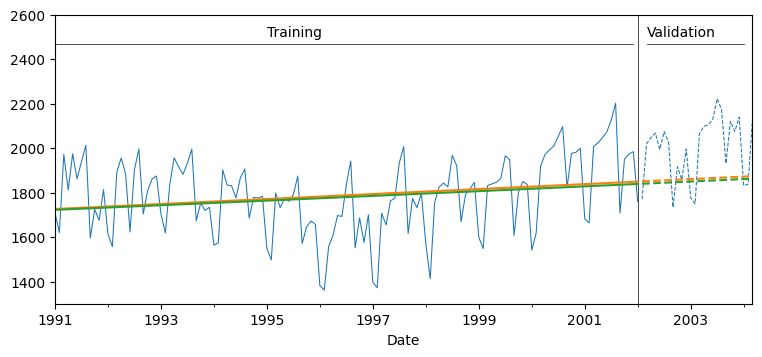

In [128]:
import numpy as np
import math
ridership_lm_linear = sm.ols(formula='Ridership ~ trend',
data=train_df).fit()
predict_df_linear = ridership_lm_linear.predict(valid_df)
ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend',
data=train_df).fit()
predict_df_expo = ridership_lm_expo.predict(valid_df)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,3.75))
train_df.plot(y='Ridership', ax=ax, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=ax, color='C0',
linestyle='dashed', linewidth=0.75)
singleGraphLayout(ax, [1300, 2600], train_df, valid_df)
ridership_lm_linear.predict(train_df).plot(color='C1')
ridership_lm_linear.predict(valid_df).plot(color='C1',
linestyle='dashed')
ridership_lm_expo.predict(train_df).apply(lambda row:
math.exp(row)).plot(color='C2')
ridership_lm_expo.predict(valid_df).apply(lambda row:
math.exp(row)).plot(color='C2',
linestyle='dashed')
ax.get_legend().remove()
plt.show()